# Summary

**This notebook takes predictions formatted the same way as submissions from previous competitions to simulate n brackets.**

- The predictions should have the columns `ID` and `Pred`. Where ID has the following format year_team1_team2 and the prediction is the the predicted probability of team1 winning against team2. 

- Setting `n_brackets=1` and `sim=False` will give you a single full-chalk bracket for each tournament.

Update: Found an inefficiency in the rng of my code after looking at this [simulation notebook](https://www.kaggle.com/code/goodspellr/seed-benchmark-submission) for the Seed-Benchmark by Good Spellr. Updated version should be much faster. Further performance improvements after suggestion by Ryan Armstrong to [precompute the random-values](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/discussion/482696#2690435).

In [17]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

# Set the number of brackets to simulate
n_brackets = 100000

# Load and filter data
round_slots = pd.read_csv('./march-machine-learning-mania-2025/MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2024]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds_m = pd.read_csv("march-machine-learning-mania-2025/MNCAATourneySeeds.csv")

# CHANGE TO 2025 FOR FINAL SIMULATION
seeds_m = seeds_m[seeds_m['Season'] == 2024]

seeds_w = pd.read_csv("march-machine-learning-mania-2025/WNCAATourneySeeds.csv")

# CHANGE TO 2025 FOR FINAL SIMULATION
seeds_w = seeds_w[seeds_w['Season'] == 2024]

preds = pd.read_csv('./submission.csv') 
preds['ID'] = preds['ID'].str.split('_')

# Have to fix X16, Y10, Y16, Z10 (change for 2025 seeds when we get them)
# X16 = Wagner = 1447
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'X16', 'TeamID': 1447}])], ignore_index=True)
# Y10 = Colorado St = 1161
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'Y10', 'TeamID': 1161}])], ignore_index=True)
# Y16 = Grambling = 1212
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'Y16', 'TeamID': 1212}])], ignore_index=True)
# Z10 = Colorado = 1160
seeds_m = pd.concat([seeds_m, pd.DataFrame([{'Season': 2024, 'Seed': 'Z10', 'TeamID': 1160}])], ignore_index=True)

In [18]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []
    
    # Precompute random-values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
# result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
# result_w['Tournament'] = 'W'
submission = result_m
# submission = pd.concat([result_m, result_w])

submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|██████████| 100000/100000 [00:02<00:00, 41330.85it/s]


In [19]:
submission.to_csv('bracket_simulations.csv')
submission

,Bracket,Slot,Team,Tournament
RowId,,,,
0,1,R1W1,W01,M
1,1,R1W2,W02,M
2,1,R1W3,W03,M
3,1,R1W4,W04,M
4,1,R1W5,W05,M
...,...,...,...,...
6299995,100000,R4Y1,Y03,M
6299996,100000,R4Z1,Z04,M
6299997,100000,R5WX,W02,M


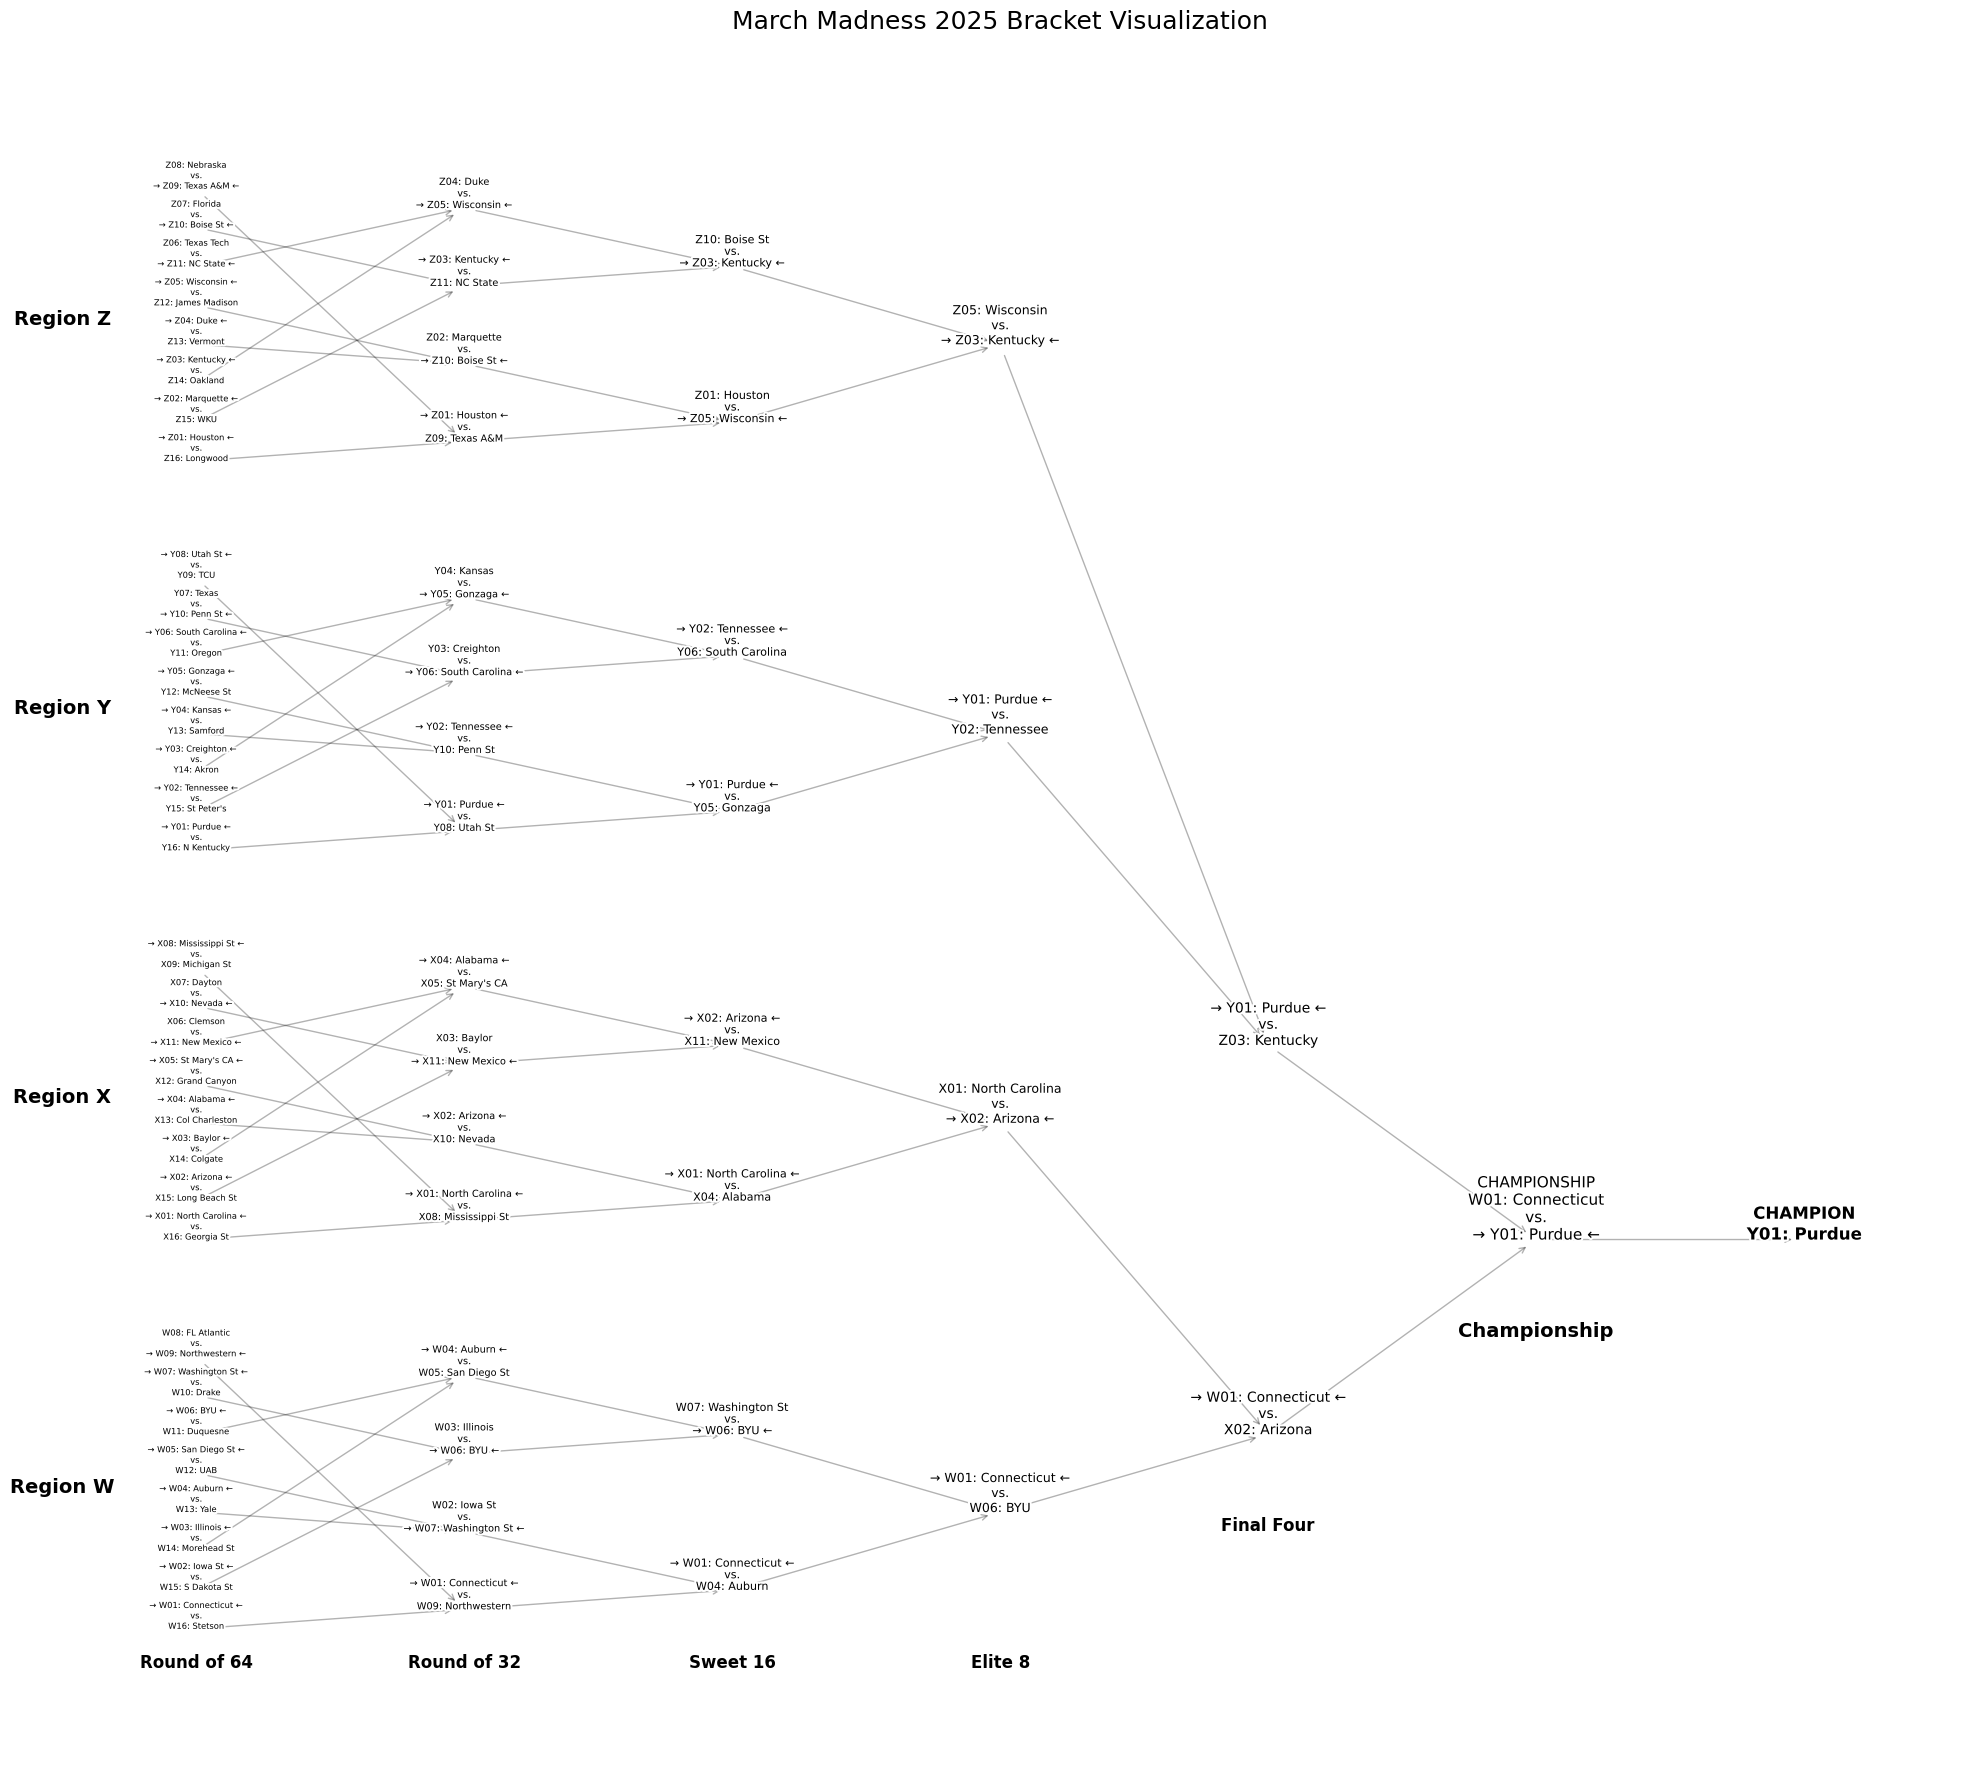

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patheffects as PathEffects

bracket = 1 # Choose the bracket number to visualize

# Load the necessary data
teams = pd.read_csv("march-machine-learning-mania-2025/MTeams.csv")
submission = pd.read_csv('bracket_simulations.csv')

submission = submission[submission['Bracket'] == bracket]
round_slots = pd.read_csv("march-machine-learning-mania-2025/MNCAATourneySlots.csv")
round_slots = round_slots[round_slots['Season'] == 2024]
round_slots = round_slots[round_slots['Slot'].str.contains('R')]  # Filter out First Four

# Merge the seeds_m dataframe with the teams dataframe to get team names
seeds_m = pd.read_csv("march-machine-learning-mania-2025/MNCAATourneySeeds.csv")
seeds_m = seeds_m.merge(teams[['TeamID', 'TeamName']], on='TeamID')

# Create a dictionary to map seeds to team names
team_info = {}
for _, row in seeds_m.iterrows():
    team_info[row['Seed']] = {
        'TeamName': row['TeamName'],
        'TeamID': row['TeamID']
    }

# Get winners from submission
slot_winners = {row['Slot']: row['Team'] for _, row in submission.iterrows()}

# Create mapping from slots to teams
slot_to_teams = {}

# First, set up the initial round matchups (R1)
for _, row in round_slots.iterrows():
    if row['Slot'].startswith('R1'):
        slot_to_teams[row['Slot']] = {
            'teams': [row['StrongSeed'], row['WeakSeed']],
            'winner': slot_winners.get(row['Slot'])
        }

# Then, for subsequent rounds, use the slots data to determine matchups
for round_num in range(2, 7):
    for _, row in round_slots.iterrows():
        if row['Slot'].startswith(f'R{round_num}'):
            # The teams in this slot are the winners from the previous slots
            strong_slot = row['StrongSeed']
            weak_slot = row['WeakSeed']
            
            # Get winner from each slot
            strong_winner = slot_winners.get(strong_slot)
            weak_winner = slot_winners.get(weak_slot)
            
            if strong_winner and weak_winner:
                slot_to_teams[row['Slot']] = {
                    'teams': [strong_winner, weak_winner],
                    'winner': slot_winners.get(row['Slot'])
                }

# Create a graph for the bracket structure
G = nx.DiGraph()

# Define regions and rounds
regions = ['W', 'X', 'Y', 'Z']
rounds = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6CH']

# Set up positions for nodes
pos = {}
x_spacing = 2
y_spacing = 1

# Add nodes and edges for each matchup
# For Round 1 (Round of 64)
for i, region in enumerate(regions):
    region_offset = i * 20
    for j in range(1, 9):
        matchup_node = f"R1{region}{j}"
        G.add_node(matchup_node)
        pos[matchup_node] = (0, region_offset + (j-1) * 2)

# For Round 2 (Round of 32)
for i, region in enumerate(regions):
    region_offset = i * 20 + 1
    for j in range(1, 5):
        matchup_node = f"R2{region}{j}"
        G.add_node(matchup_node)
        pos[matchup_node] = (x_spacing, region_offset + (j-1) * 4)
        
        # Connect to previous round
        if j == 1:
            G.add_edge(f"R1{region}1", matchup_node)
            G.add_edge(f"R1{region}8", matchup_node)
        elif j == 2:
            G.add_edge(f"R1{region}4", matchup_node)
            G.add_edge(f"R1{region}5", matchup_node)
        elif j == 3:
            G.add_edge(f"R1{region}2", matchup_node)
            G.add_edge(f"R1{region}7", matchup_node)
        elif j == 4:
            G.add_edge(f"R1{region}3", matchup_node)
            G.add_edge(f"R1{region}6", matchup_node)

# For Round 3 (Sweet 16)
for i, region in enumerate(regions):
    region_offset = i * 20 + 2
    for j in range(1, 3):
        matchup_node = f"R3{region}{j}"
        G.add_node(matchup_node)
        pos[matchup_node] = (x_spacing * 2, region_offset + (j-1) * 8)
        
        # Connect to previous round
        if j == 1:
            G.add_edge(f"R2{region}1", matchup_node)
            G.add_edge(f"R2{region}2", matchup_node)
        elif j == 2:
            G.add_edge(f"R2{region}3", matchup_node)
            G.add_edge(f"R2{region}4", matchup_node)

# For Round 4 (Elite 8)
for i, region in enumerate(regions):
    matchup_node = f"R4{region}1"
    G.add_node(matchup_node)
    pos[matchup_node] = (x_spacing * 3, i * 20 + 6)
    
    # Connect to previous round
    G.add_edge(f"R3{region}1", matchup_node)
    G.add_edge(f"R3{region}2", matchup_node)

# For Round 5 (Final Four)
G.add_node("R5WX")
pos["R5WX"] = (x_spacing * 4, 10)
G.add_edge("R4W1", "R5WX")
G.add_edge("R4X1", "R5WX")

G.add_node("R5YZ")
pos["R5YZ"] = (x_spacing * 4, 30)
G.add_edge("R4Y1", "R5YZ")
G.add_edge("R4Z1", "R5YZ")

# For Championship
G.add_node("R6CH")
pos["R6CH"] = (x_spacing * 5, 20)
G.add_edge("R5WX", "R6CH")
G.add_edge("R5YZ", "R6CH")

# Champion node
G.add_node("CHAMPION")
pos["CHAMPION"] = (x_spacing * 6, 20)
G.add_edge("R6CH", "CHAMPION")

# Create a figure with appropriate dimensions
plt.figure(figsize=(20, 18))

# Draw the bracket structure
nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True, arrowstyle='->')

# Add team labels to each node
for node, position in pos.items():
    if node in slot_to_teams:
        teams = slot_to_teams[node]['teams']
        winner = slot_to_teams[node]['winner']
        
        # Get team names
        team1_name = team_info.get(teams[0], {}).get('TeamName', teams[0])
        team2_name = team_info.get(teams[1], {}).get('TeamName', teams[1])
        
        # Create label
        label_text = f"{teams[0]}: {team1_name}\nvs.\n{teams[1]}: {team2_name}"
        
        # Highlight winner
        if winner:
            winner_name = team_info.get(winner, {}).get('TeamName', winner)
            if winner == teams[0]:
                label_text = f"→ {teams[0]}: {team1_name} ←\nvs.\n{teams[1]}: {team2_name}"
            else:
                label_text = f"{teams[0]}: {team1_name}\nvs.\n→ {teams[1]}: {team2_name} ←"
        
        # Adjust font size based on round
        if node.startswith('R1'):
            fontsize = 6
        elif node.startswith('R2'):
            fontsize = 7
        elif node.startswith('R3'):
            fontsize = 8
        elif node.startswith('R4'):
            fontsize = 9
        elif node.startswith('R5'):
            fontsize = 10
        else:  # Championship
            fontsize = 11
            label_text = f"CHAMPIONSHIP\n{label_text}"
        
        # Add text with background
        text = plt.text(position[0], position[1], label_text, 
                    horizontalalignment='center',
                    fontsize=fontsize)
        text.set_path_effects([
            PathEffects.withStroke(linewidth=3, foreground='white')
        ])
    
    # Add champion
    elif node == "CHAMPION":
        winner = slot_winners.get("R6CH")
        if winner:
            winner_name = team_info.get(winner, {}).get('TeamName', winner)
            label_text = f"CHAMPION\n{winner}: {winner_name}"
            
            text = plt.text(position[0], position[1], label_text, 
                        horizontalalignment='center',
                        fontsize=12,
                        fontweight='bold')
            text.set_path_effects([
                PathEffects.withStroke(linewidth=3, foreground='white')
            ])

# Add region labels
for i, region in enumerate(regions):
    region_label = f"Region {region}"
    plt.text(-1, i * 20 + 7, region_label, fontsize=14, 
             horizontalalignment='center', fontweight='bold')

# Add round labels
round_names = {
    'R1': 'Round of 64',
    'R2': 'Round of 32', 
    'R3': 'Sweet 16',
    'R4': 'Elite 8',
    'R5': 'Final Four',
    'R6': 'Championship'
}

for i, r in enumerate(['R1', 'R2', 'R3', 'R4']):
    plt.text(i * x_spacing, -2, round_names[r], fontsize=12, 
             horizontalalignment='center', fontweight='bold')

plt.text(x_spacing * 4, 5, round_names['R5'], fontsize=12, 
         horizontalalignment='center', fontweight='bold')
plt.text(x_spacing * 5, 15, round_names['R6'], fontsize=14, 
         horizontalalignment='center', fontweight='bold')

# Remove axes
plt.axis('off')
plt.title('March Madness 2025 Bracket Visualization', fontsize=18)
plt.tight_layout()
plt.savefig('bracket_visualization.png', dpi=300, bbox_inches='tight')
plt.show()